## Сборный проект-2: Удовлетворенность сотрудников

### Описание проекта 

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 



#### Задачи 

1) Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. 

Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.


2) Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Нужные библиотеки и загрузка данных

In [2]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

# библиотека для оценки важности признаков Шепли (SHAP)
import shap

# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE


# библиотеки для пайплайнов
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score


# библиотеки для логистической регрессии
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# библиотека для метода опорных векторов
from sklearn.svm import SVC

# библиотека решающих деревьев
from sklearn.tree import DecisionTreeClassifier


# бибилиотека для графика ROC-кривой и расчёта ROC-AUC
from sklearn.metrics import roc_auc_score, RocCurveDisplay


# библиотека для модели классификации kNN 
from sklearn.neighbors import KNeighborsClassifier

# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
import plotly.express as px 
import plotly.graph_objects as go



Читаем исходные датасеты

In [3]:
try:
    train_job_satisfaction_rate_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    train_quit_df = pd.read_csv('/datasets/train_quit.csv')
    test_features_df = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate_df= pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')#, sep=';',decimal=',')
    test_target_quit_df = pd.read_csv('/datasets/test_target_quit.csv')

except FileNotFoundError:
    train_job_satisfaction_rate_df = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/data/train_job_satisfaction_rate.csv')
    train_quit_df = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/data/train_quit.csv')
    test_features_df = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/data/test_features.csv')
    test_target_job_satisfaction_rate_df= pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/data/test_target_job_satisfaction_rate.csv')#, sep=';',decimal=',')
    test_target_quit_df = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/data/test_target_quit.csv')


In [4]:
# функция получения имени датасета

def get_dataset_name(variable):
    import inspect
    frame = inspect.currentframe()
    for scope in [frame.f_back.f_globals, frame.f_back.f_locals]:
        for var_name, var_val in scope.items():
            if isinstance(var_val, pd.DataFrame) and var_val is variable:
                del frame
                return var_name


In [5]:
# функция выбора цвета для текста output 

from IPython.display import Markdown, display

def print_red(text):
    display(Markdown(f'<span style="color:red">{text}</span>'))

Выводим информацию об исходных датасетах

In [6]:
for df in [train_job_satisfaction_rate_df, train_quit_df, test_features_df, test_target_job_satisfaction_rate_df, test_target_quit_df]:
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals
    dataset_name = get_dataset_name(df)
    # pd.set_option('display.max_rows', None)

    print_red(f'Информация по таблице {dataset_name}')
    display(df.head())
    print()
    display(df.info())
    print()
    

<span style="color:red">Информация по таблице train_job_satisfaction_rate_df</span>

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

<span style="color:red">Информация по таблице train_quit_df</span>

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

<span style="color:red">Информация по таблице test_features_df</span>

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<span style="color:red">Информация по таблице test_target_job_satisfaction_rate_df</span>

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

<span style="color:red">Информация по таблице test_target_quit_df</span>

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

### Задача 1: предсказание уровня удовлетворённости сотрудника

#### Шаг 1-2 Загрузка и предобработка данных

Признаки от заказчика:

        id — уникальный идентификатор сотрудника;
        dept — отдел, в котором работает сотрудник;
        level — уровень занимаемой должности;
        workload — уровень загруженности сотрудника;
        employment_years — длительность работы в компании (в годах);
        last_year_promo — показывает, было ли повышение за последний год;
        last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
        supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
        salary — ежемесячная зарплата сотрудника;
        job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

В таблице train_job_satisfaction_rate_df есть пропуски в столбцах dept и level. выведем эти значения

In [7]:
train_job_satisfaction_rate_df.query('dept != dept | level != level')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Информация ничего не дала, посмотрим какие департаменты и уровни вообще есть 

In [9]:
for feat in ['dept', 'level']:
    print(train_job_satisfaction_rate_df[feat].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]


In [10]:
train_job_satisfaction_rate_df.groupby('level').agg({'salary': 'median'})

,salary
level,
junior,24000.0
middle,39600.0
sinior,56400.0


Можно построить распределения и boxplot, посмотреть пороговые значения для зарплат по уровням сотрудников и таким образом принять решение о заполнении пропусков.

Аналогичную выборку можно провести по департаментам уже после заполнения уровней (группировать по департаменту и уровню сотрудника) - и тоже заполнить пропуски.

Но с другой стороны - пустых значений всего 10 из 4000 - это 0,25% - просто удалим их

In [13]:
train_job_satisfaction_rate_df.dropna(inplace=True)

In [14]:
train_job_satisfaction_rate_df.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [15]:
train_job_satisfaction_rate_df.shape

(3990, 10)

Проверим на дубликаты

In [12]:
train_job_satisfaction_rate_df.duplicated().sum()

0

Дубликатов нет, посмотрим на неявные дубликаты/ опечатки

In [17]:
for feat in ['dept', 'level', 'workload']:
    print(train_job_satisfaction_rate_df[feat].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing']
['junior' 'middle' 'sinior']
['medium' 'high' 'low']


Никаких дубликатов в таблице нет.

Смотрим на таблицу test_features.csv

In [19]:
test_features_df.duplicated().sum()

0

In [21]:
for feat in ['dept', 'level', 'workload']:
    print(test_features_df[feat].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']


неявных дубликатов нет, но есть и пропуски, и пустые значения , выведем эти строки

In [29]:
test_features_df[
                (test_features_df.dept.isna() )| 
                  (test_features_df.dept == ' ' ) |
                  (test_features_df.workload == ' ' )|
                  (test_features_df.level.isna())
                  ]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


аналогично, пропусков и пустых значений всего 0.25% - пренебрегаем ими, удалим

In [43]:
test_features_df.dropna(inplace=True)
test_features_df = test_features_df[
                  (test_features_df.dept != ' ' ) &
                  (test_features_df.workload != ' ' )
                  ]

In [44]:
test_features_df[
                (test_features_df.dept.isna() )| 
                  (test_features_df.dept == ' ' ) |
                  (test_features_df.workload == ' ' )|
                  (test_features_df.level.isna())
                  ]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [45]:
test_features_df.shape

(1995, 9)

смотрим таблицу test_target_job_satisfaction_rate.csv - выше оценили, с ней проблем нет

еще раз посмотрим, что у нас получилось

In [47]:
for df in [train_job_satisfaction_rate_df, test_features_df, test_target_job_satisfaction_rate_df]:
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals
    dataset_name = get_dataset_name(df)
    # pd.set_option('display.max_rows', None)

    print_red(f'Информация по таблице {dataset_name}')
    display(df.head())
    print()
    display(df.info())
    print()
    

<span style="color:red">Информация по таблице train_job_satisfaction_rate_df</span>

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3990 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3990 non-null   int64  
 1   dept                   3990 non-null   object 
 2   level                  3990 non-null   object 
 3   workload               3990 non-null   object 
 4   employment_years       3990 non-null   int64  
 5   last_year_promo        3990 non-null   object 
 6   last_year_violations   3990 non-null   object 
 7   supervisor_evaluation  3990 non-null   int64  
 8   salary                 3990 non-null   int64  
 9   job_satisfaction_rate  3990 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 342.9+ KB


None

<span style="color:red">Информация по таблице test_features_df</span>

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     1995 non-null   int64 
 1   dept                   1995 non-null   object
 2   level                  1995 non-null   object
 3   workload               1995 non-null   object
 4   employment_years       1995 non-null   int64 
 5   last_year_promo        1995 non-null   object
 6   last_year_violations   1995 non-null   object
 7   supervisor_evaluation  1995 non-null   int64 
 8   salary                 1995 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 155.9+ KB


None

<span style="color:red">Информация по таблице test_target_job_satisfaction_rate_df</span>

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

#### Вывод по шагам 1-2: 

- дубликатов нет
- пустые значения удалены, они занимают всего 0.25% от всех данных

#### Шаг 3. Анализ данных

Разделим все столбцы на категориальные и количественные данные, переведем id в индексы

In [58]:
for df in [train_job_satisfaction_rate_df, test_features_df, test_target_job_satisfaction_rate_df]:
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals
    dataset_name = get_dataset_name(df)

    # уводим id в индексы
    df.set_index('id', inplace=True)

    # создаем новые переменные, имена назначаем от имени датасета
    globals()[f"{dataset_name}_cat_col"] =  df.select_dtypes(exclude='number').columns.tolist()
    globals()[f"{dataset_name}_num_col"] =   df.select_dtypes(include='number').columns.tolist()


    print_red(f'Категориальные и количественные столбцы для {dataset_name}')
    print(f'Категориальные столбцы {globals()[f"{dataset_name}_cat_col"]}')
    print(f'Количественные столбцы {globals()[f"{dataset_name}_num_col"] }')
    print()
    

<span style="color:red">Категориальные и количественные столбцы для train_job_satisfaction_rate_df</span>

Категориальные столбцы ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Количественные столбцы ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']



<span style="color:red">Категориальные и количественные столбцы для test_features_df</span>

Категориальные столбцы ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Количественные столбцы ['employment_years', 'supervisor_evaluation', 'salary']



<span style="color:red">Категориальные и количественные столбцы для test_target_job_satisfaction_rate_df</span>

Категориальные столбцы []
Количественные столбцы ['job_satisfaction_rate']



Создадим 4 функции:

- вытягивания имени из переменной (для корректного наименования графиков)
- построения гистограммы и boxplot для количественных признаков
- построения столбчатых диаграмм для категориальных признаков

- сборная функция построения всей аналитики для любого датасета

In [60]:
# функция получения имени переменной

def get_var_name(var, caller_locals):
    import inspect
    for name, value in caller_locals.items():
        if value is var:
            return name
    return None

In [61]:
# функция для построения гистограммы и boxplot для любого столбца любого датафрейма

def plot_hist_boxplot(some_df, col, col_name, dataset_name):

    df_for_plot= some_df[col]

    # Рассчитываем квартили
    q25, q75 = df_for_plot.quantile(0.25), df_for_plot.quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    # Создаем новый график
    plt.figure(figsize=(10, 10))

    # Строим гистограмму
    plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, график 1
    plt.hist(df_for_plot, bins=20, range=(min_val, max_val))
    plt.title(f'Гистограмма для признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значения признака {col_name}')
    plt.ylabel(f'Частота')


    # Помечаем квартили на гистограмме
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()

    # Строим график boxplot
    plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, график 2
    plt.boxplot(df_for_plot, vert=False)
    plt.title(f'Boxplot признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'Значение признака {col_name}')

    # Помечаем квартили на boxplot
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()


    # Показываем графики
    plt.tight_layout()  # Для автоматического выравнивания графиков
    plt.show()


        

In [62]:
# функция построения столбчатой диаграммы

def barplot_df(dataset, col, col_name, dataset_name):
    dataset[col].value_counts().plot(kind='bar', legend=True, figsize=(10,5))
    plt.title(f'Диаграмма частоты признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значение признака {col_name}')
    plt.ylabel(f'Частота признака {col_name}')
    plt.show()

    

In [66]:
# функция получения аналитических данных для любой таблицы

def analysis_df(some_df: pd.DataFrame, cat_list: list, num_list: list):
    # блок вытягивания имени
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals

    dataset_name = get_var_name(some_df, caller_locals)
    

    print_red(f'Статистический анализ таблицы {dataset_name}')  # печатаем имя таблицы (из переменной)
    display(some_df.describe().T)

    # блок построения гистограмм и диаграмм

    for col in num_list:
        plot_hist_boxplot(some_df=some_df, col_name=col, col=col, dataset_name=dataset_name)

    for col in cat_list:   # для категориальных столбцов
        try:
            barplot_df(dataset=some_df, col_name=col, col=col, dataset_name=dataset_name)
        except KeyError:
            continue

Запускаем цикл аналитики по каждому датасету

<span style="color:red">Статистический анализ таблицы train_job_satisfaction_rate_df</span>

,count,mean,std,min,25%,50%,75%,max
employment_years,3990.0,3.722055,2.543715,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,3990.0,3.475188,1.009238,1.00,3.00,4.00,4.00,5.0
salary,3990.0,33953.383459,14907.247698,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,3990.0,0.533772,0.225353,0.03,0.36,0.56,0.71,1.0


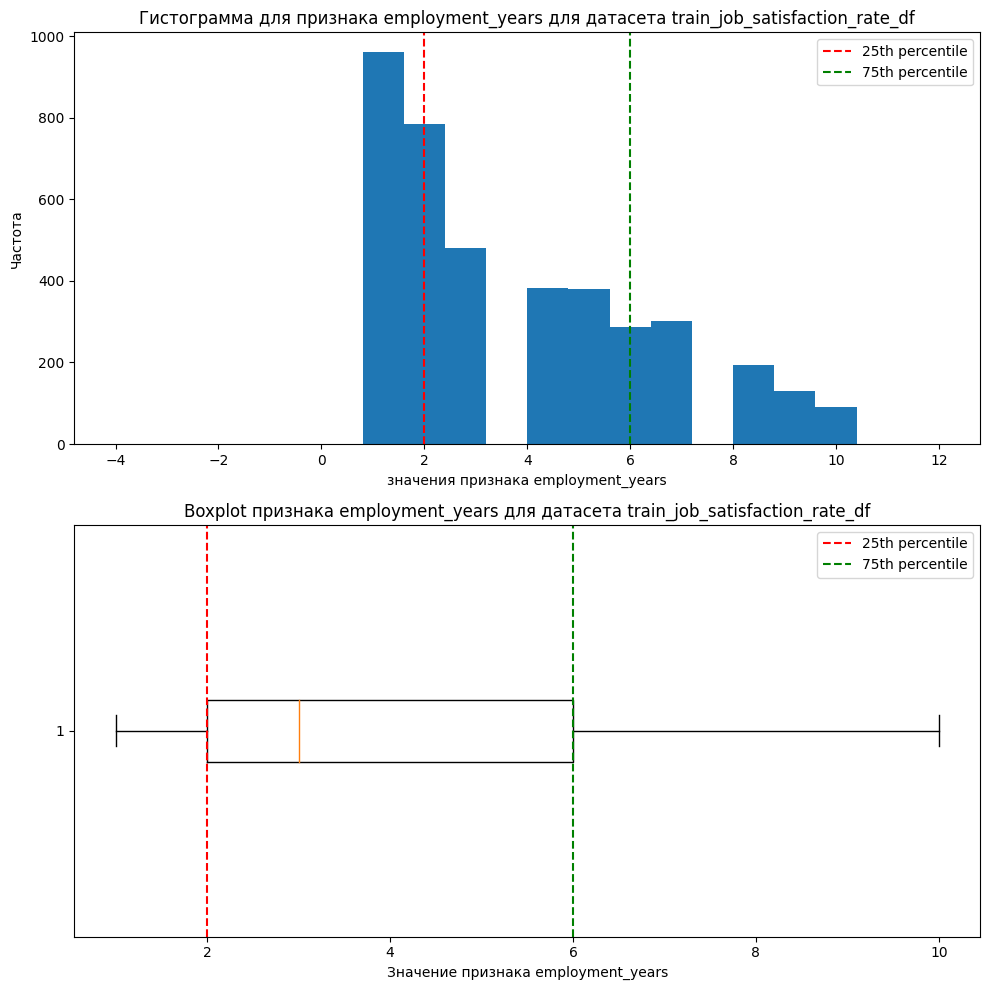

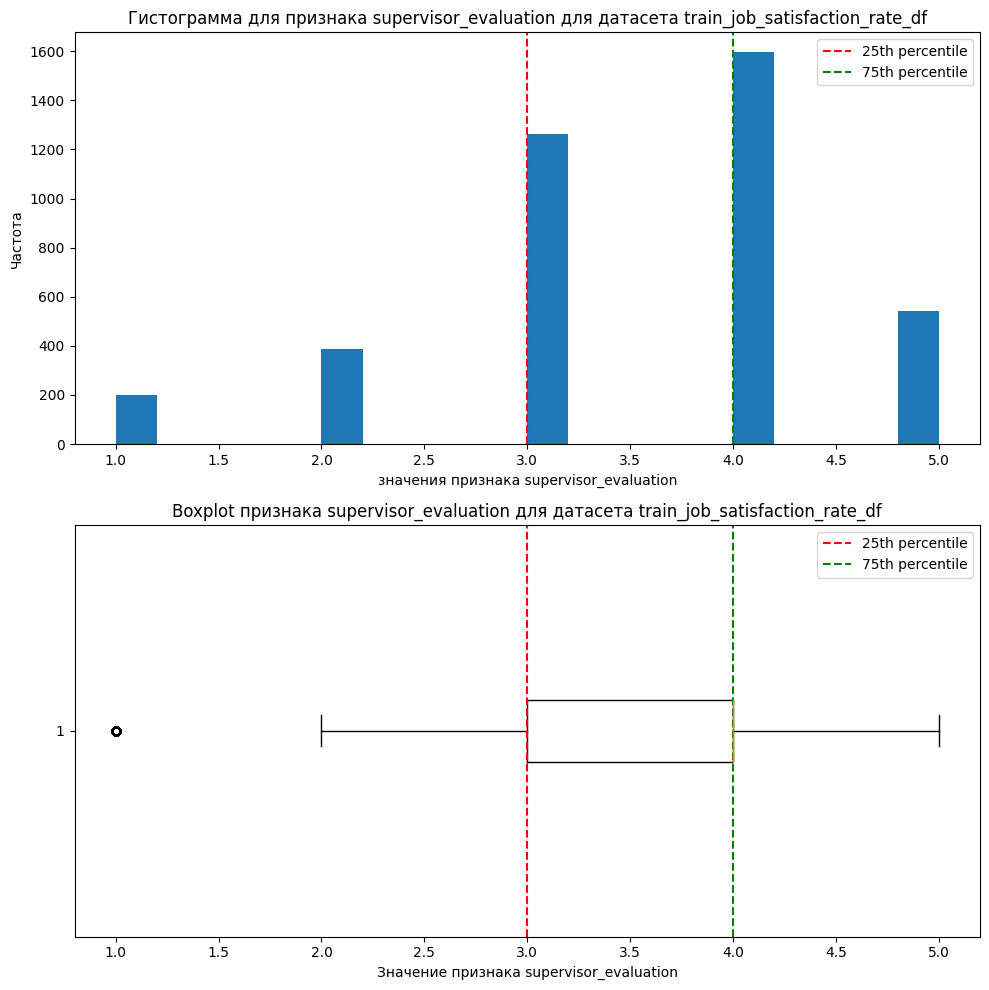

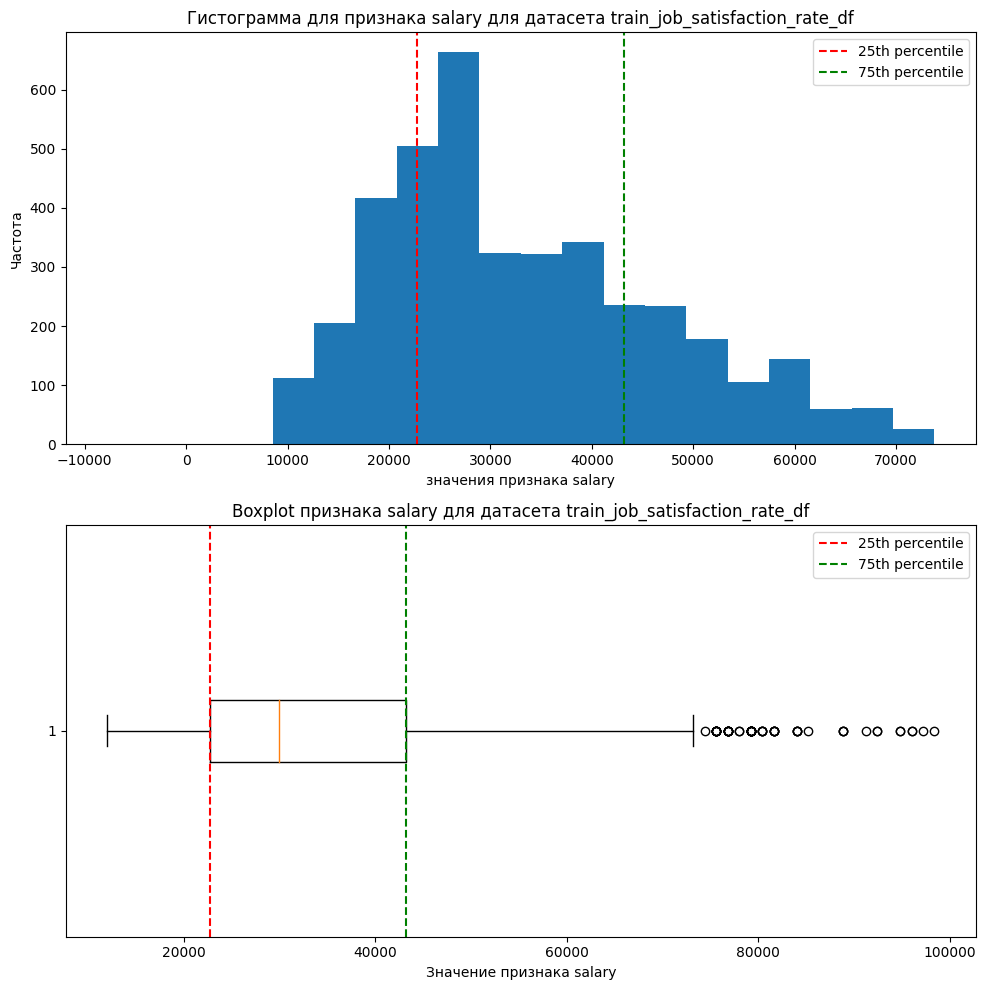

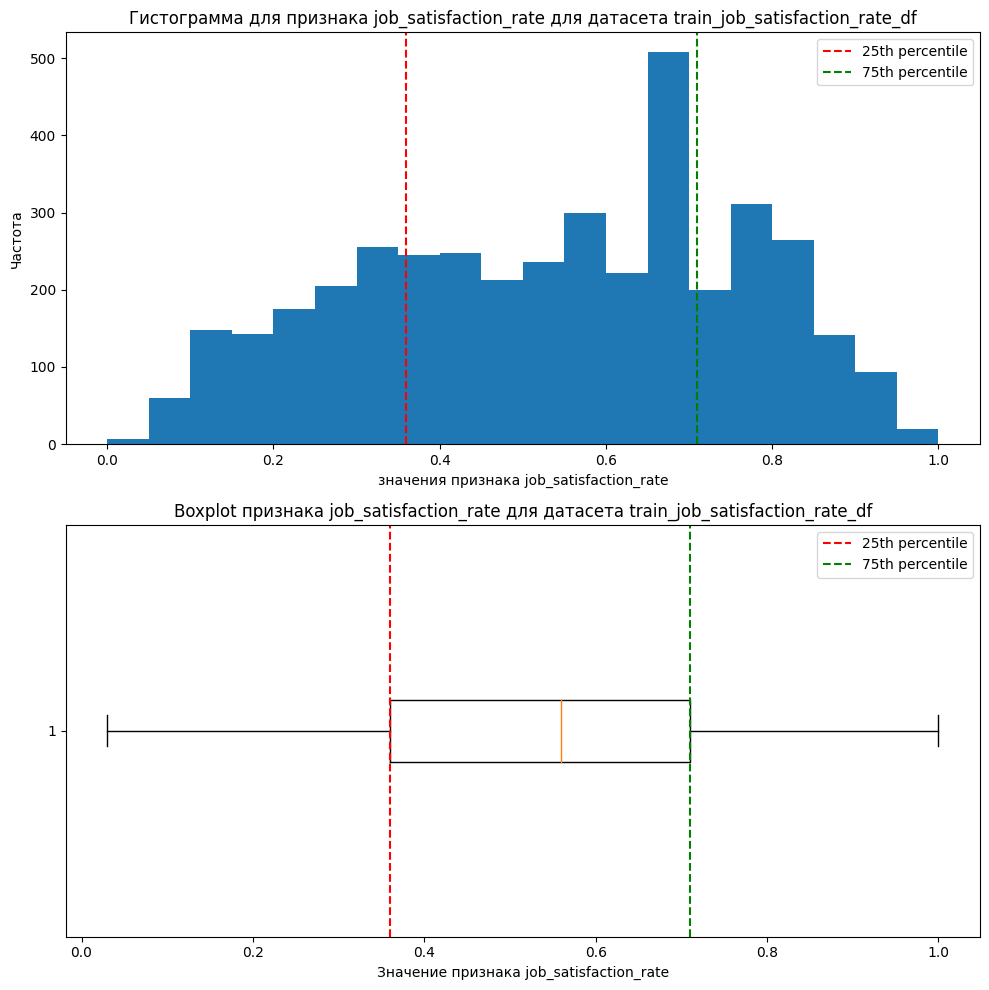

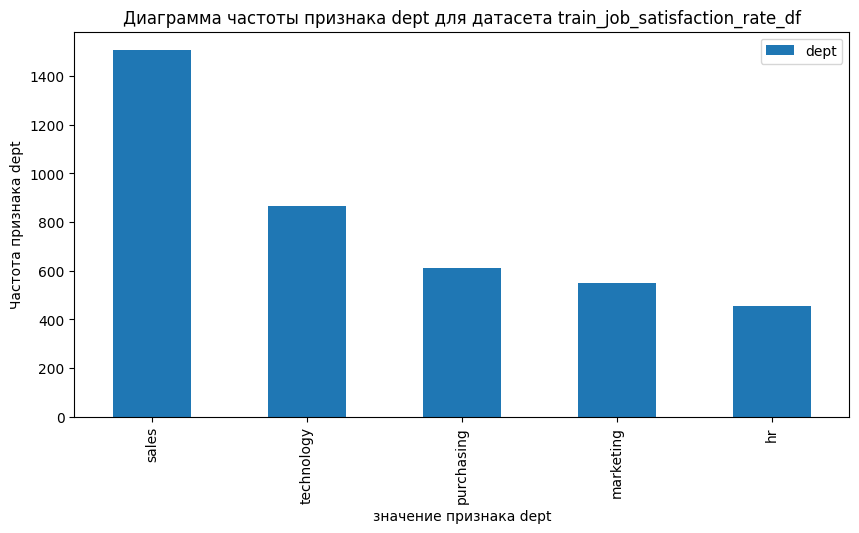

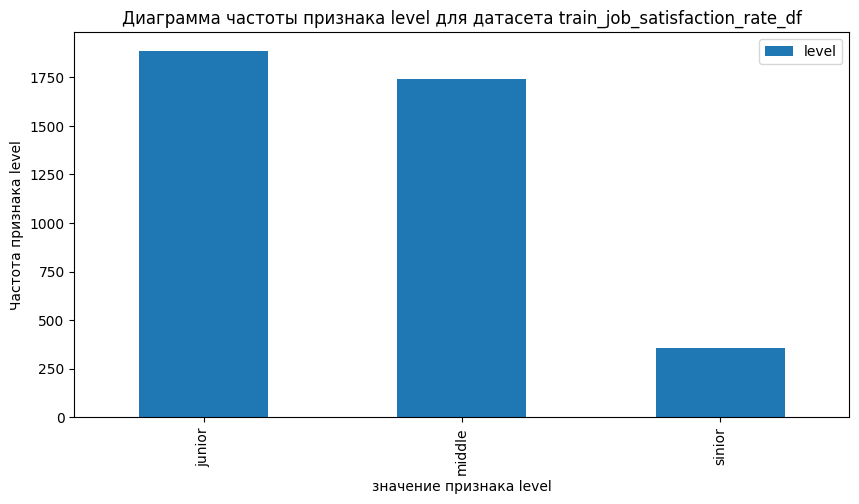

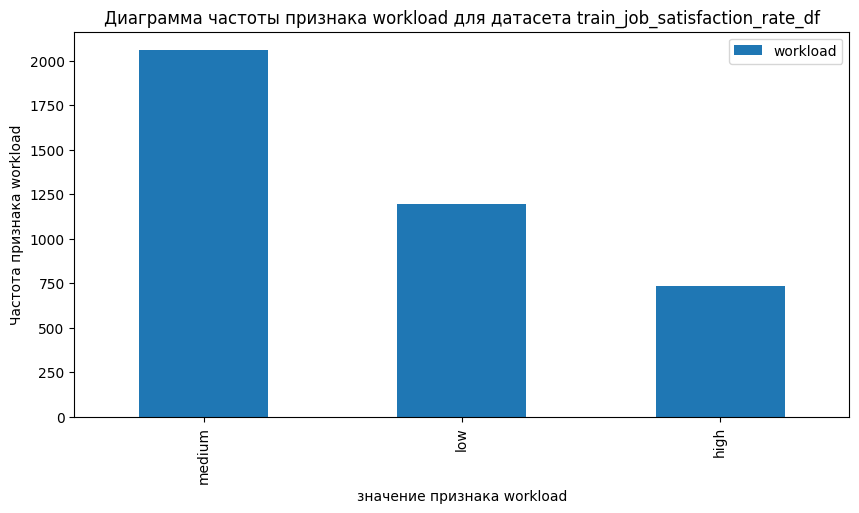

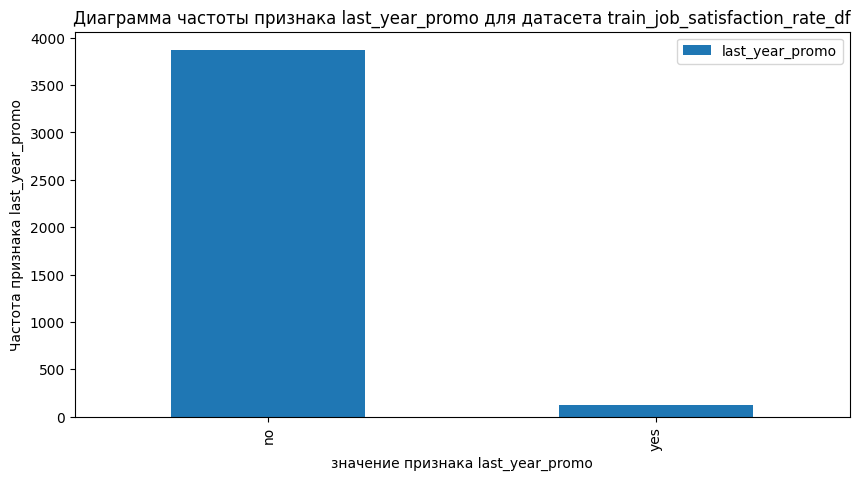

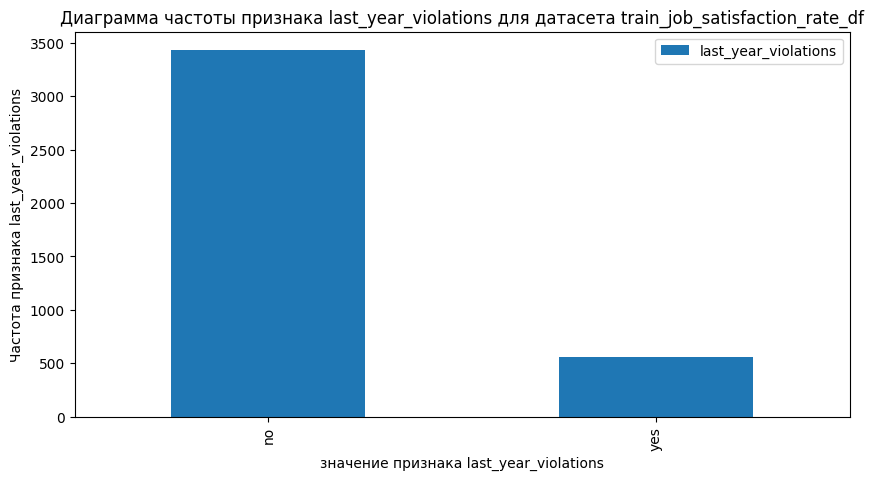

<span style="color:red">Статистический анализ таблицы test_features_df</span>

,count,mean,std,min,25%,50%,75%,max
employment_years,1995.0,3.670677,2.538237,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,1995.0,3.527318,0.996297,1.0,3.0,4.0,4.0,5.0
salary,1995.0,34087.819549,15405.546390,12000.0,22800.0,30000.0,43200.0,96000.0


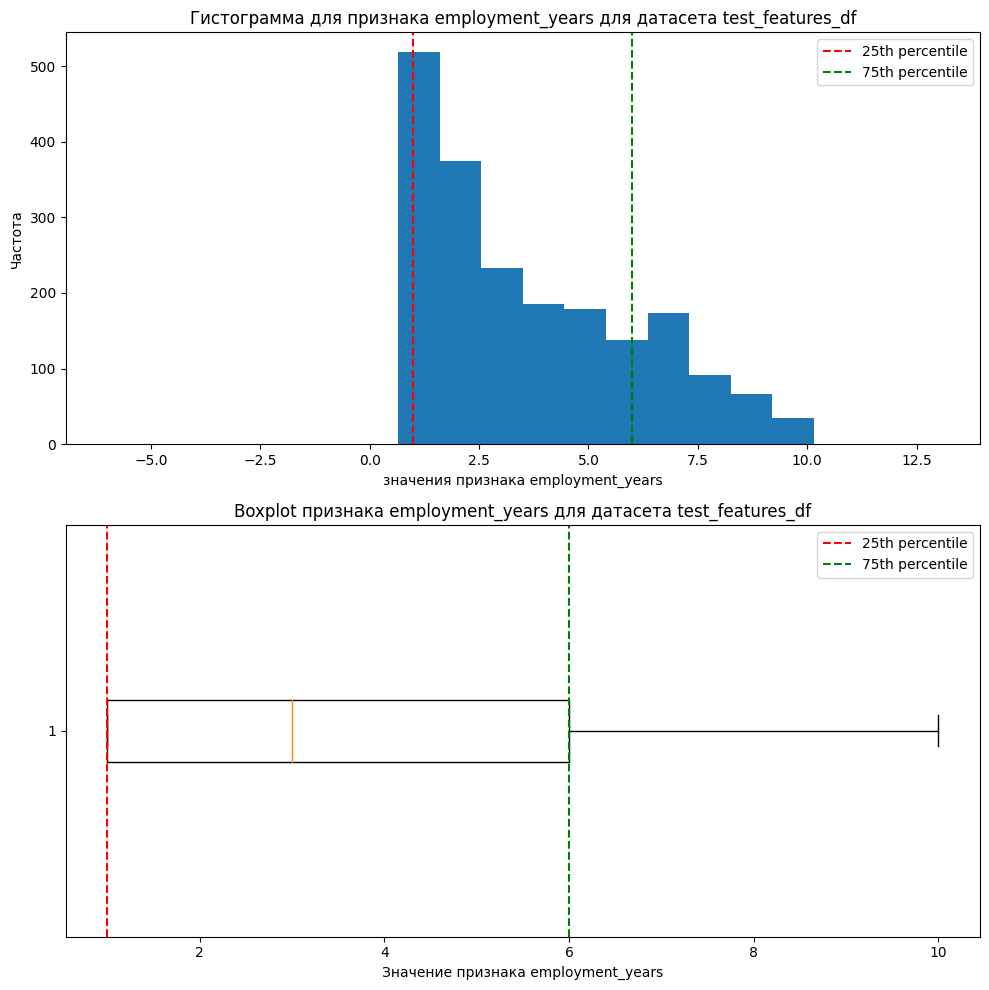

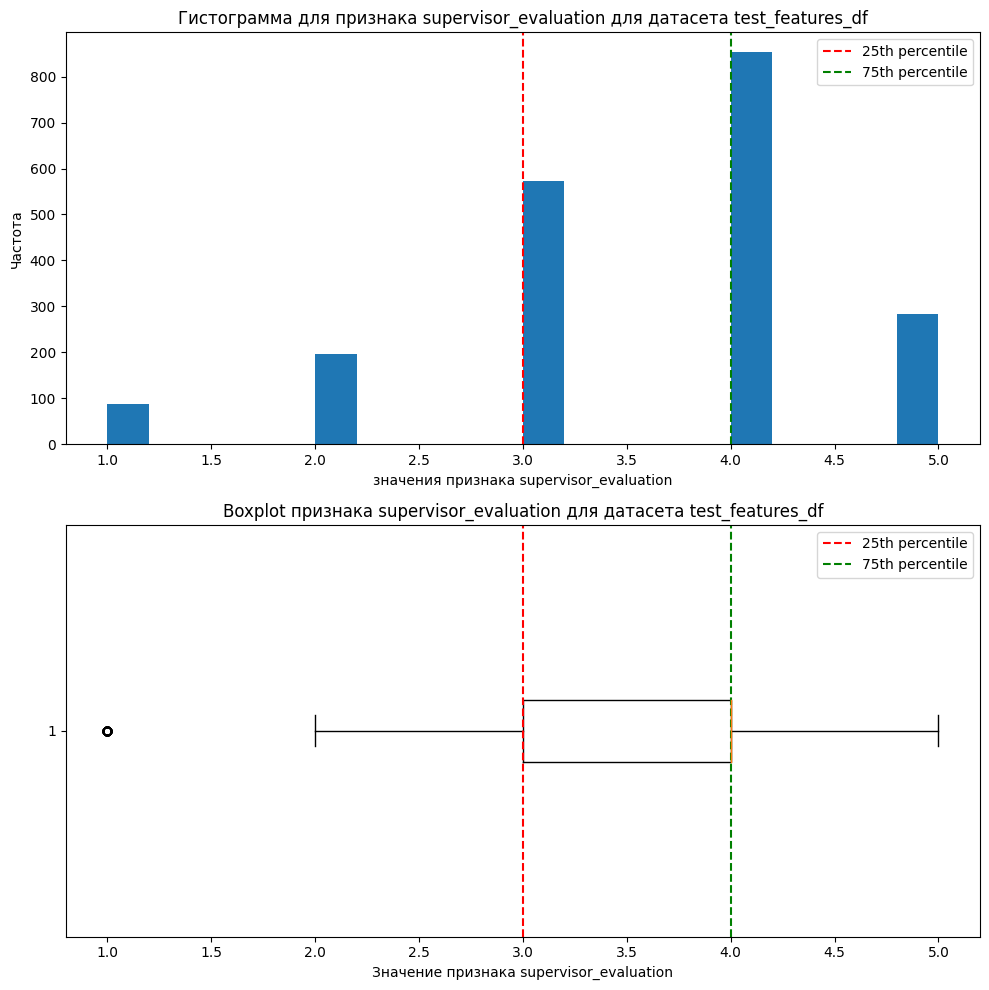

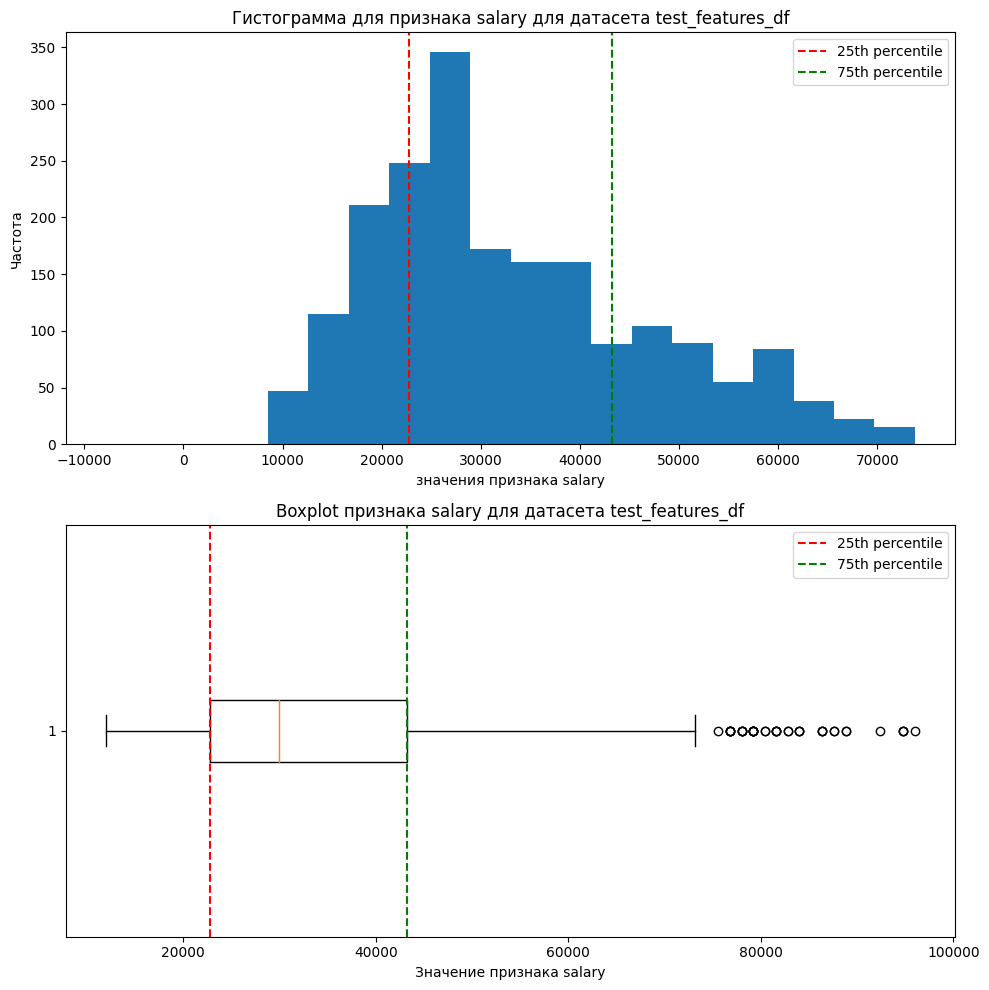

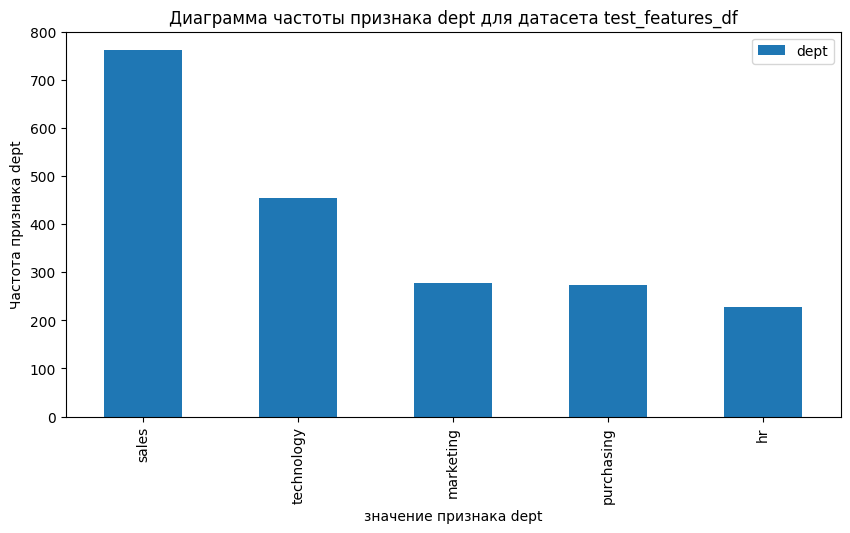

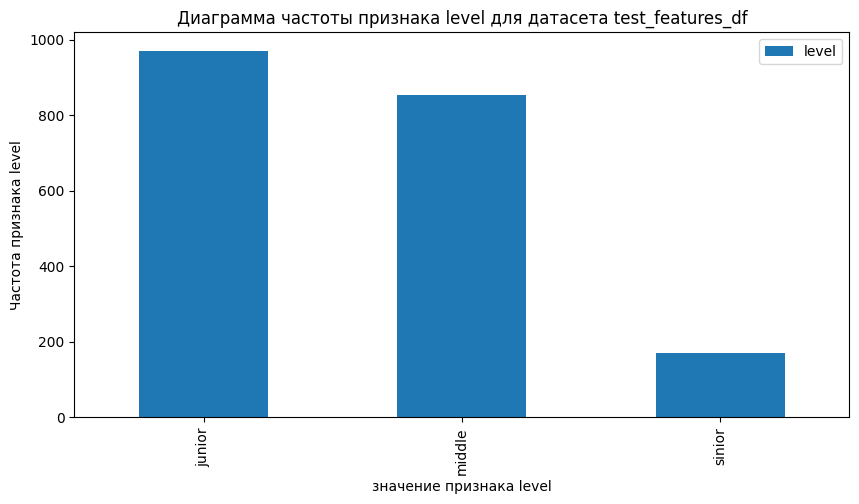

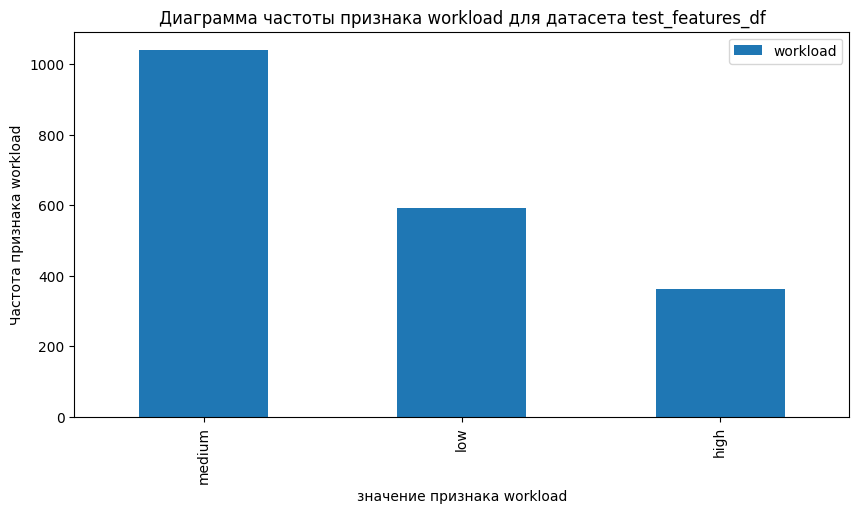

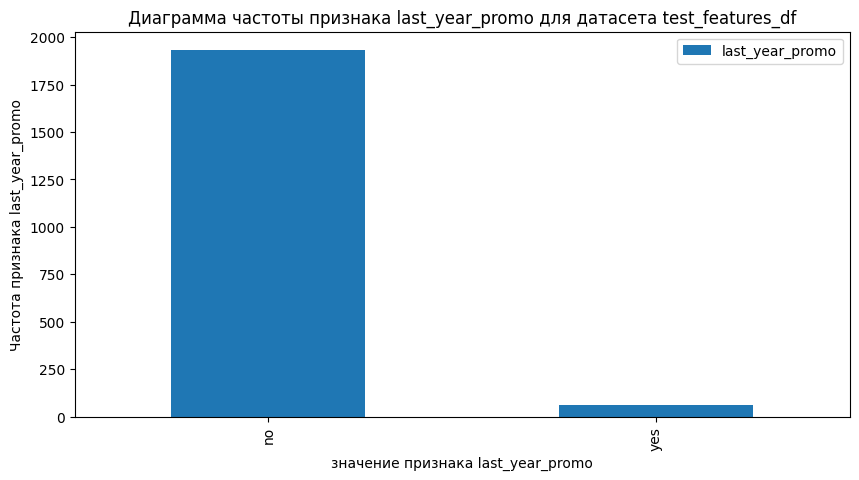

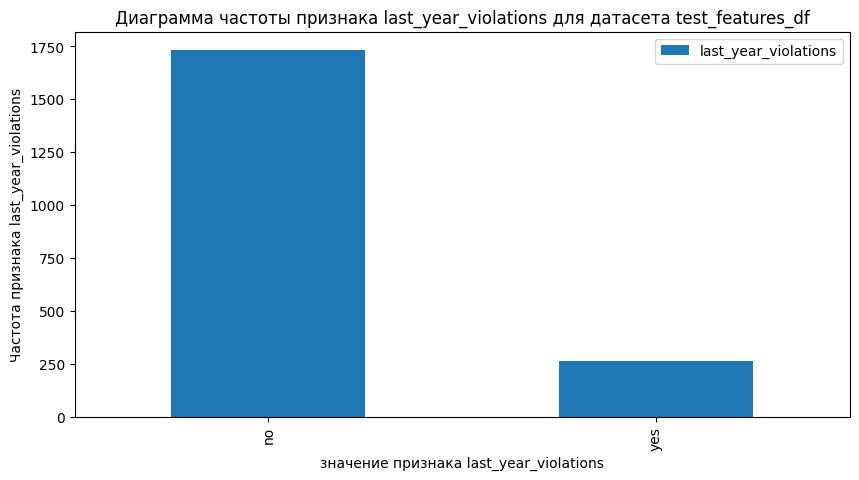

<span style="color:red">Статистический анализ таблицы test_target_job_satisfaction_rate_df</span>

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


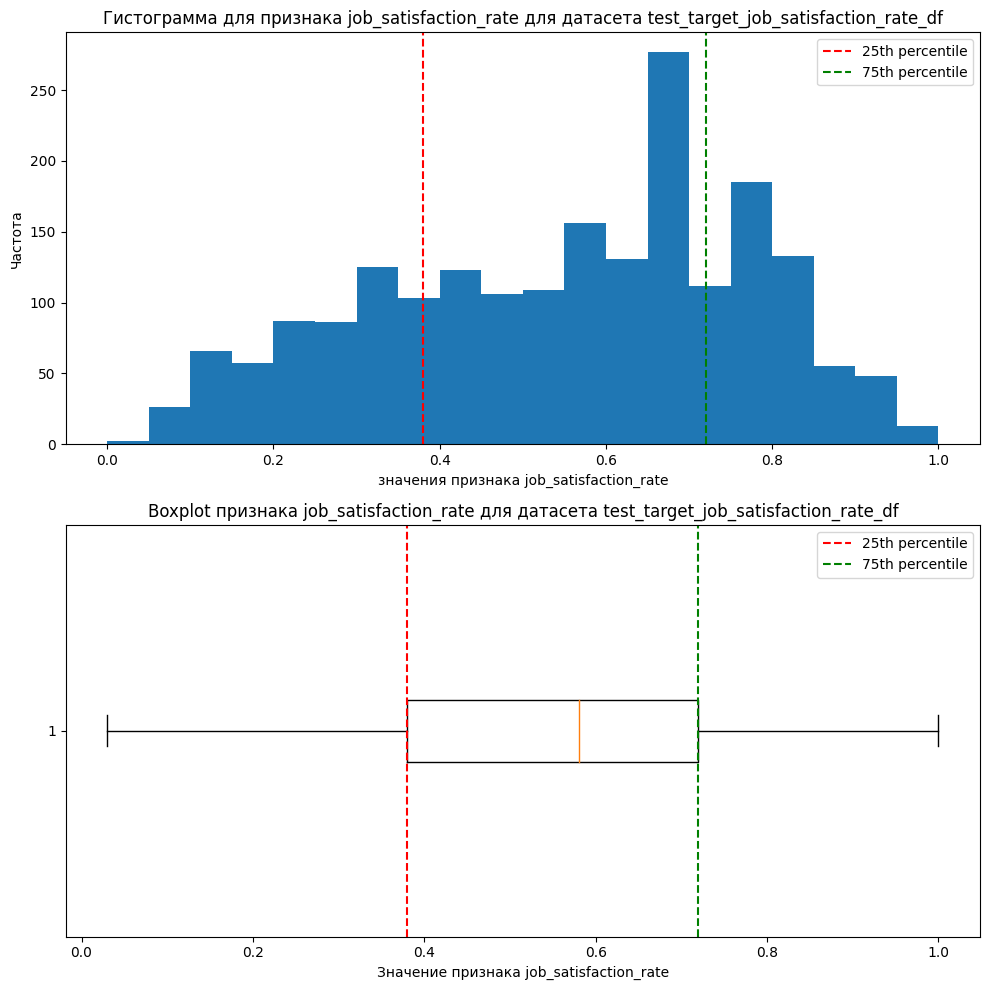

In [68]:
for df in [train_job_satisfaction_rate_df, test_features_df, test_target_job_satisfaction_rate_df]:
    # забираем имя датасета
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals
    dataset_name = get_dataset_name(df)

    # забираем список категориальных и количественных столбцов
    cat_list= globals()[f"{dataset_name}_cat_col"]
    num_list = globals()[f"{dataset_name}_num_col"]

    analysis_df(df, cat_list=cat_list, num_list=num_list)

    

#### Выводы по анализу данных

1) Таблица train_job_satisfaction_rate.csv